In [ ]:
# Step 1: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

sns.set(style="whitegrid", palette="muted", font_scale=1.1)

In [ ]:
# Step 2: Load dataset
data = pd.read_excel("QVI_data.xlsx")

print(data.head())
print(data.info())


   LYLTY_CARD_NBR       DATE  STORE_NBR  TXN_ID  PROD_NBR  \
0            1000 2018-10-17          1       1         5   
1            1002 2018-09-16          1       2        58   
2            1003 2019-03-07          1       3        52   
3            1003 2019-03-08          1       4       106   
4            1004 2018-11-02          1       5        96   

                                PROD_NAME  PROD_QTY  TOT_SALES  PACK_SIZE  \
0  Natural Chip        Compny SeaSalt175g         2        6.0        175   
1   Red Rock Deli Chikn&Garlic Aioli 150g         1        2.7        150   
2   Grain Waves Sour    Cream&Chives 210G         1        3.6        210   
3  Natural ChipCo      Hony Soy Chckn175g         1        3.0        175   
4          WW Original Stacked Chips 160g         1        1.9        160   

        BRAND              LIFESTAGE PREMIUM_CUSTOMER  
0     NATURAL  YOUNG SINGLES/COUPLES          Premium  
1         RRD  YOUNG SINGLES/COUPLES       Mainstream  
2 

In [ ]:
# Step 3: Prepare time columns
data['DATE'] = pd.to_datetime(data['DATE'])
data['MONTH'] = data['DATE'].dt.to_period('M')

In [ ]:
# Step 4: Define trial stores
trial_stores = [77, 86, 88]

In [ ]:
# Step 5: Aggregate monthly metrics
metrics = data.groupby(['STORE_NBR', 'MONTH']).agg(
    TOT_SALES=('TOT_SALES', 'sum'),
    CUSTOMERS=('LYLTY_CARD_NBR', 'nunique'),
    TXNS=('TXN_ID', 'nunique')
).reset_index()

metrics['AVG_TXN_PER_CUST'] = metrics['TXNS'] / metrics['CUSTOMERS']

print(metrics.head())

   STORE_NBR    MONTH  TOT_SALES  CUSTOMERS  TXNS  AVG_TXN_PER_CUST
0          1  2018-07      206.9         49    52          1.061224
1          1  2018-08      176.1         42    43          1.023810
2          1  2018-09      278.8         59    62          1.050847
3          1  2018-10      188.1         44    45          1.022727
4          1  2018-11      192.6         46    47          1.021739


In [ ]:
# Step 6: Function to find control store
def find_control_store(trial_store, metric_col):
    """
    Compares trial store's metric history with all other stores.
    Uses correlation to pick the best matching control store.
    """
    trial_history = metrics[metrics['STORE_NBR'] == trial_store][['MONTH', metric_col]]
    best_match = None
    best_corr = -1

    for store in metrics['STORE_NBR'].unique():
        if store == trial_store:
            continue
        control_history = metrics[metrics['STORE_NBR'] == store][['MONTH', metric_col]]
        merged = pd.merge(trial_history, control_history, on='MONTH', suffixes=('_trial', '_control'))
        corr = merged[metric_col + '_trial'].corr(merged[metric_col + '_control'])
        if corr > best_corr:
            best_corr = corr
            best_match = store
    return best_match, best_corr

In [ ]:
# Step 7: Trial period
trial_period = (metrics['MONTH'] >= '2019-02') & (metrics['MONTH'] <= '2019-04')


In [ ]:
# Step 8: Main sales results
main_results = []

for trial in trial_stores:
    control, corr = find_control_store(trial, 'TOT_SALES')
    trial_sales = metrics[(metrics['STORE_NBR'] == trial) & trial_period]['TOT_SALES']
    control_sales = metrics[(metrics['STORE_NBR'] == control) & trial_period]['TOT_SALES']

    t_stat, p_val = ttest_ind(trial_sales, control_sales, equal_var=False)

    print(f"\nTrial Store {trial} vs Control Store {control}")
    print(f"Mean Sales (Trial): {trial_sales.mean():.2f}, Mean Sales (Control): {control_sales.mean():.2f}")
    print(f"T-test p-value: {p_val:.4f}")
    if p_val < 0.05:
        print("Significant difference! Trial likely had an impact.")
    else:
        print("No significant difference. Trial may not have had an effect.")

    main_results.append({
        "Trial Store": trial,
        "Control Store": control,
        "p_value_sales": p_val,
        "Trial Sales Mean": trial_sales.mean(),
        "Control Sales Mean": control_sales.mean()
    })

results_df = pd.DataFrame(main_results)

/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2914: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2773: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2773: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2914: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2773: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2773: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/local/lib


Trial Store 77 vs Control Store 31
Mean Sales (Trial): 259.00, Mean Sales (Control): nan
T-test p-value: nan
No significant difference. Trial may not have had an effect.


/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2914: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2773: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2773: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2914: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2773: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2773: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/local/lib


Trial Store 86 vs Control Store 31
Mean Sales (Trial): 929.40, Mean Sales (Control): nan
T-test p-value: nan
No significant difference. Trial may not have had an effect.


/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2914: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2773: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2773: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2914: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2773: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2773: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/local/lib


Trial Store 88 vs Control Store 206
Mean Sales (Trial): 1428.93, Mean Sales (Control): 4.60
T-test p-value: nan
No significant difference. Trial may not have had an effect.


/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2914: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2773: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2773: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2914: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2773: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2773: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/local/lib


=== Extra Driver Tests: Trial 77 vs Control 31 ===
Customers p-value: nan
Transactions p-value: nan
Avg Txn per Customer p-value: nan


/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2914: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2773: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2773: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2914: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2773: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2773: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/local/lib


=== Extra Driver Tests: Trial 86 vs Control 31 ===
Customers p-value: nan
Transactions p-value: nan
Avg Txn per Customer p-value: nan


/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]



=== Extra Driver Tests: Trial 88 vs Control 206 ===
Customers p-value: nan
Transactions p-value: nan
Avg Txn per Customer p-value: nan

Extra driver significance tests complete!
Extended results saved to 'trial_vs_control_results_with_drivers.csv'


/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2914: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2773: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2773: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2914: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2773: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2773: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/local/lib

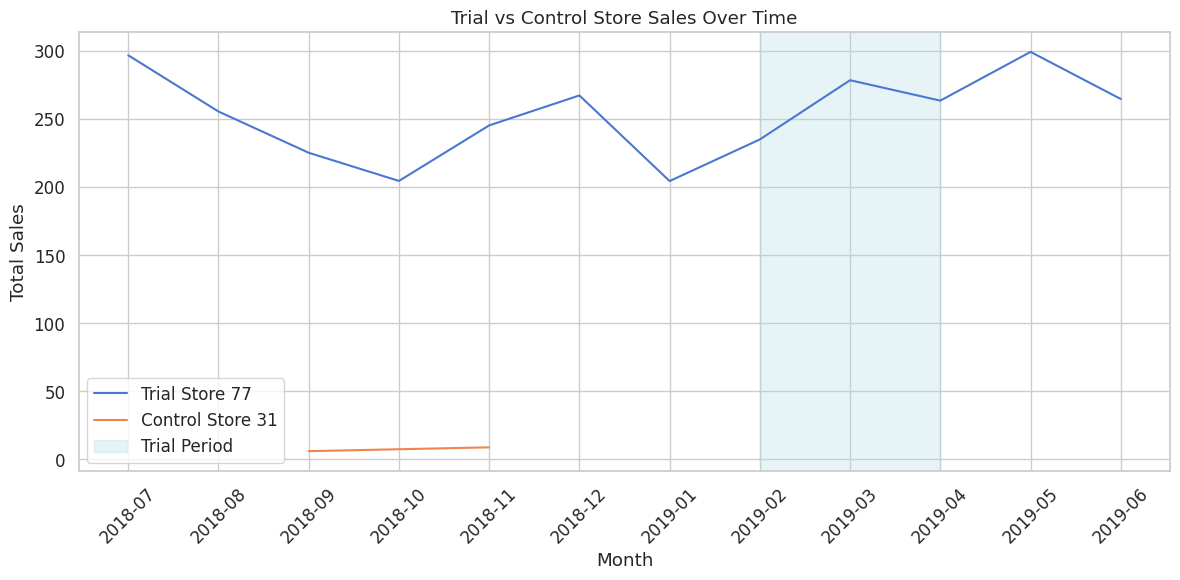

In [ ]:
# Step 9: Extra driver tests
extra_results = []

for trial in trial_stores:
    control, _ = find_control_store(trial, 'TOT_SALES')
    trial_data = metrics[(metrics['STORE_NBR'] == trial) & trial_period]
    control_data = metrics[(metrics['STORE_NBR'] == control) & trial_period]

    # Customers
    t_stat_cust, p_val_cust = ttest_ind(trial_data['CUSTOMERS'], control_data['CUSTOMERS'], equal_var=False)
    # Transactions
    t_stat_txn, p_val_txn = ttest_ind(trial_data['TXNS'], control_data['TXNS'], equal_var=False)
    # Avg transactions per customer
    t_stat_freq, p_val_freq = ttest_ind(trial_data['AVG_TXN_PER_CUST'], control_data['AVG_TXN_PER_CUST'], equal_var=False)

    print(f"\n=== Extra Driver Tests: Trial {trial} vs Control {control} ===")
    print(f"Customers p-value: {p_val_cust:.4f}")
    print(f"Transactions p-value: {p_val_txn:.4f}")
    print(f"Avg Txn per Customer p-value: {p_val_freq:.4f}")

    extra_results.append({
        "Trial Store": trial,
        "Control Store": control,
        "p_value_customers": p_val_cust,
        "p_value_transactions": p_val_txn,
        "p_value_avg_txn_per_cust": p_val_freq
    })

extra_df = pd.DataFrame(extra_results)

# Step 10: Merge and save final results
final_results = results_df.merge(extra_df, on=["Trial Store", "Control Store"])
final_results.to_csv("trial_vs_control_results_with_drivers.csv", index=False)

print("\nExtra driver significance tests complete!")
print("Extended results saved to 'trial_vs_control_results_with_drivers.csv'")

# Step 11: Visualization example (Store 77 vs control)
plt.figure(figsize=(12,6))
trial_store = 77
control_store, _ = find_control_store(trial_store, 'TOT_SALES')

trial_history = metrics[metrics['STORE_NBR'] == trial_store]
control_history = metrics[metrics['STORE_NBR'] == control_store]

plt.plot(trial_history['MONTH'].astype(str), trial_history['TOT_SALES'], label=f"Trial Store {trial_store}")
plt.plot(control_history['MONTH'].astype(str), control_history['TOT_SALES'], label=f"Control Store {control_store}")
plt.axvspan('2019-02', '2019-04', color='lightblue', alpha=0.3, label="Trial Period")
plt.xticks(rotation=45)
plt.title("Trial vs Control Store Sales Over Time")
plt.xlabel("Month")
plt.ylabel("Total Sales")
plt.legend()
plt.tight_layout()
plt.savefig("trial_vs_control_example.png")
plt.show()

/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2914: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2773: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2773: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2914: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2773: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2773: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/local/lib

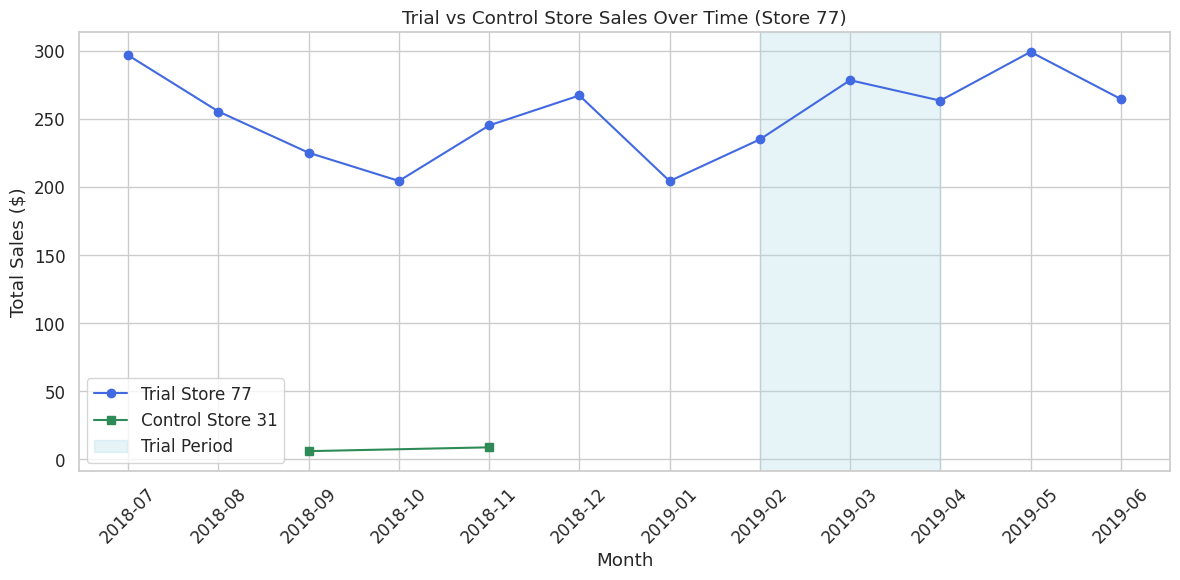

/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2914: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2773: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2773: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2914: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2773: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2773: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/local/lib

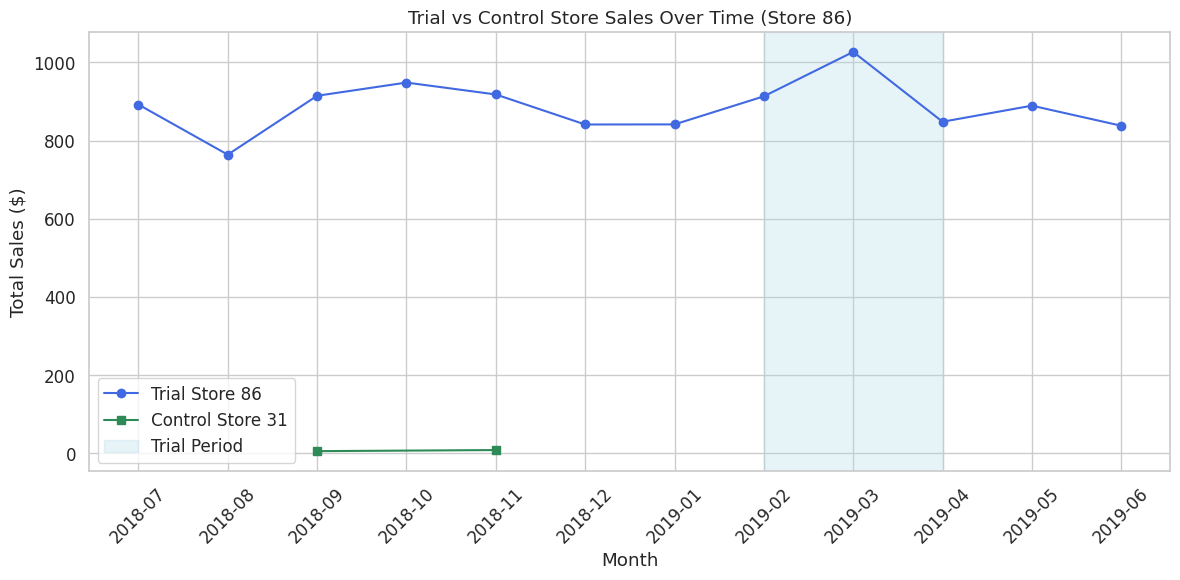

/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2914: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2773: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2773: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2914: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2773: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2773: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/local/lib

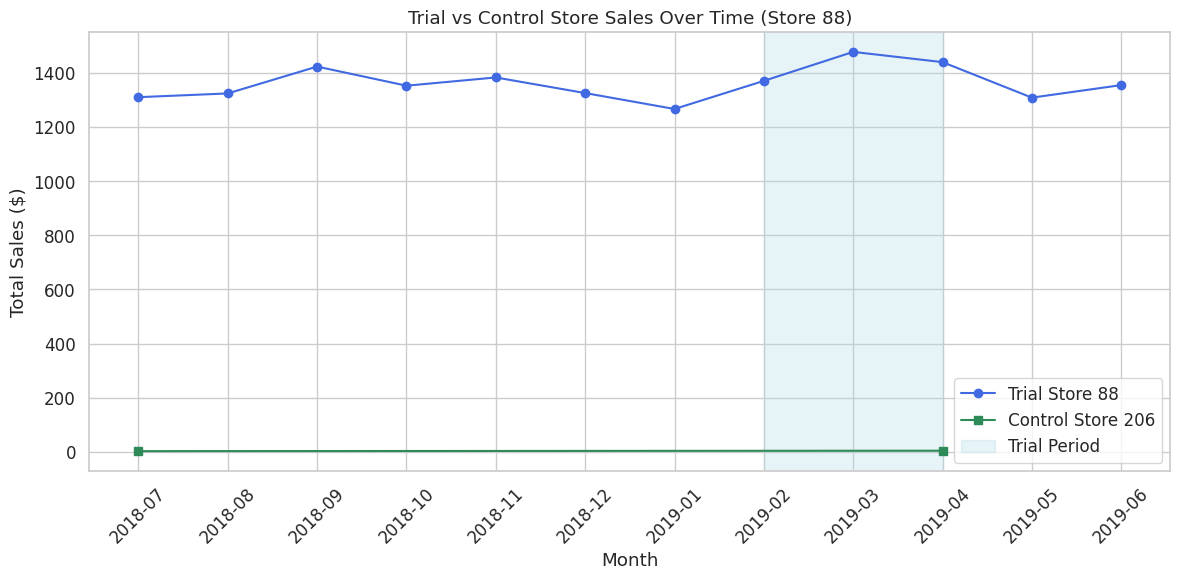

In [ ]:
# === Extra Charts for All Trial Stores ===
trial_stores = [77, 86, 88]

for trial in trial_stores:
    control, _ = find_control_store(trial, 'TOT_SALES')

    trial_history = metrics[metrics['STORE_NBR'] == trial]
    control_history = metrics[metrics['STORE_NBR'] == control]

    plt.figure(figsize=(12,6))
    plt.plot(trial_history['MONTH'].astype(str), trial_history['TOT_SALES'],
             label=f"Trial Store {trial}", color="royalblue", marker="o")
    plt.plot(control_history['MONTH'].astype(str), control_history['TOT_SALES'],
             label=f"Control Store {control}", color="seagreen", marker="s")
    plt.axvspan('2019-02', '2019-04', color='lightblue', alpha=0.3, label="Trial Period")
    plt.xticks(rotation=45)
    plt.title(f"Trial vs Control Store Sales Over Time (Store {trial})")
    plt.xlabel("Month")
    plt.ylabel("Total Sales ($)")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"trial_vs_control_store_{trial}.png", dpi=300)
    plt.show()

/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2914: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2773: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2773: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2914: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2773: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2773: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/local/lib

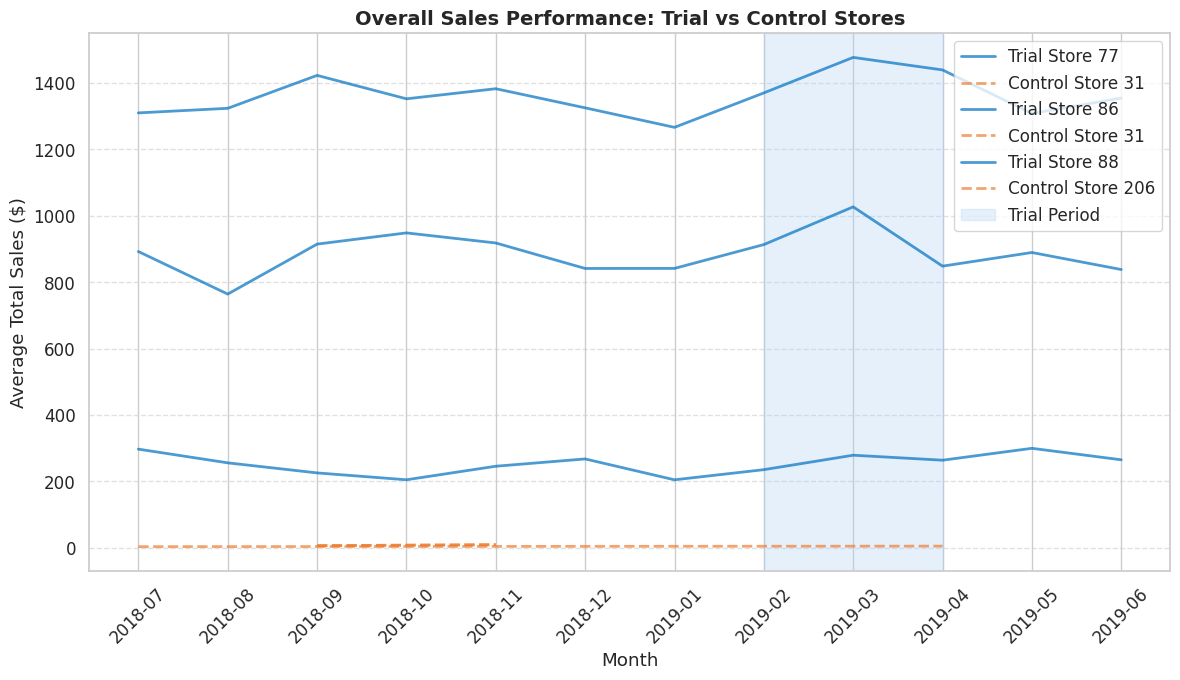

In [ ]:
# === Combined Overall Performance Chart (All Trial Stores vs Their Controls) ===
trial_stores = [77, 86, 88]  # ensure defined

trial_color = "#0070C0"    # Blue for Trial
control_color = "#ED7D31"  # Orange for Control
shade_color = "#A9D0F5"    # Light blue for trial period shading

plt.figure(figsize=(12,7))

for trial in trial_stores:
    control, _ = find_control_store(trial, 'TOT_SALES')

    # Aggregate monthly totals for trial vs control
    trial_history = metrics[metrics['STORE_NBR'] == trial].groupby('MONTH')['TOT_SALES'].mean()
    control_history = metrics[metrics['STORE_NBR'] == control].groupby('MONTH')['TOT_SALES'].mean()

    plt.plot(trial_history.index.astype(str), trial_history.values,
             label=f"Trial Store {trial}", color=trial_color, linewidth=2, alpha=0.7)
    plt.plot(control_history.index.astype(str), control_history.values,
             label=f"Control Store {control}", color=control_color, linewidth=2, alpha=0.7, linestyle="--")

# Highlight trial period
plt.axvspan('2019-02', '2019-04', color=shade_color, alpha=0.3, label="Trial Period")

plt.title("Overall Sales Performance: Trial vs Control Stores", fontsize=14, fontweight='bold')
plt.xlabel("Month")
plt.ylabel("Average Total Sales ($)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(axis='y', linestyle="--", alpha=0.6)
plt.tight_layout()
plt.savefig("overall_trial_vs_control_performance.png", dpi=300)
plt.show()

/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2914: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2773: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_func

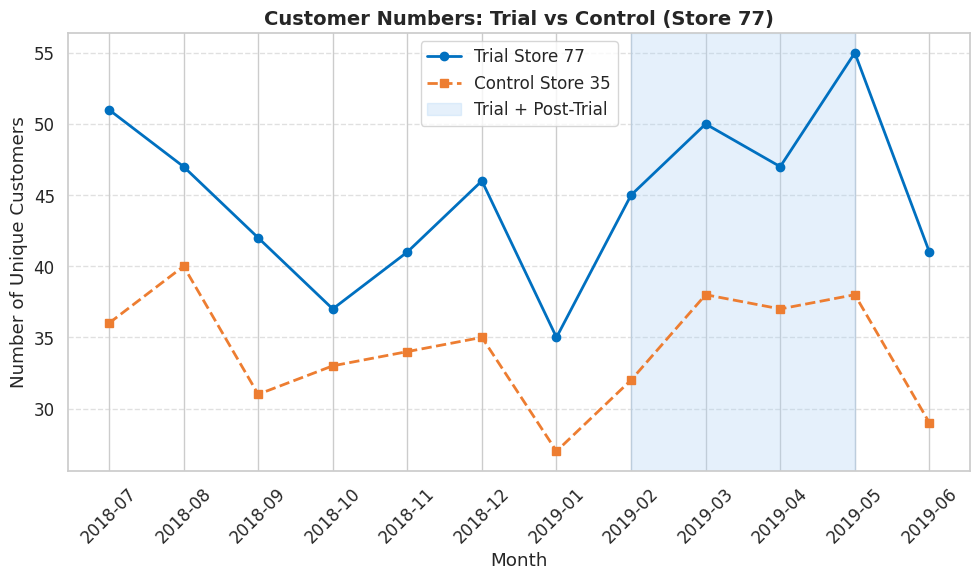

/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2914: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2773: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_func

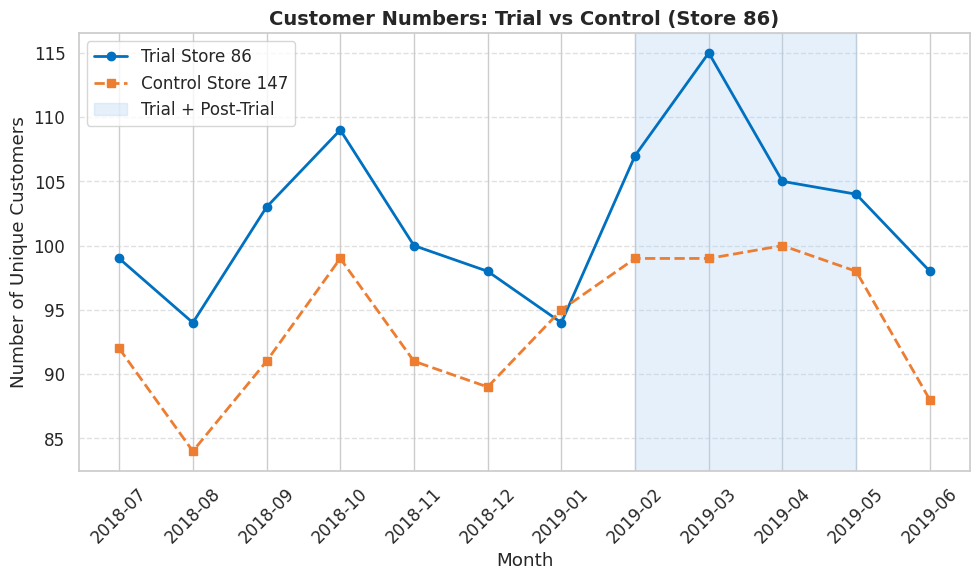

/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2914: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2773: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_func

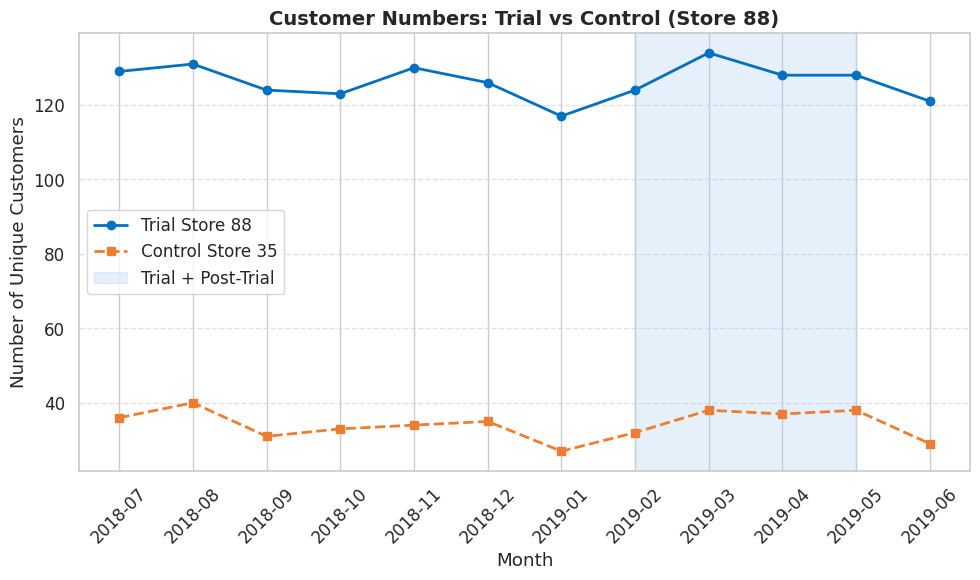

In [ ]:
# === Customer Numbers During and After Trial Period (Feb–May 2019) ===
trial_stores = [77, 86, 88]  # make sure defined

trial_color = "#0070C0"    # Blue for Trial
control_color = "#ED7D31"  # Orange for Control
shade_color = "#A9D0F5"    # Light blue for trial period shading

for trial in trial_stores:
    control, _ = find_control_store(trial, 'CUSTOMERS')

    trial_cust = metrics[metrics['STORE_NBR'] == trial].groupby('MONTH')['CUSTOMERS'].mean()
    control_cust = metrics[metrics['STORE_NBR'] == control].groupby('MONTH')['CUSTOMERS'].mean()

    plt.figure(figsize=(10,6))
    plt.plot(trial_cust.index.astype(str), trial_cust.values,
             label=f"Trial Store {trial}", color=trial_color, marker="o", linewidth=2)
    plt.plot(control_cust.index.astype(str), control_cust.values,
             label=f"Control Store {control}", color=control_color, marker="s", linewidth=2, linestyle="--")

    # Highlight trial period (Feb–Apr) + extended to May
    plt.axvspan('2019-02', '2019-05', color=shade_color, alpha=0.3, label="Trial + Post-Trial")

    plt.title(f"Customer Numbers: Trial vs Control (Store {trial})", fontsize=14, fontweight="bold")
    plt.xlabel("Month")
    plt.ylabel("Number of Unique Customers")
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(axis='y', linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.savefig(f"customer_numbers_trial_store_{trial}.png", dpi=300)
    plt.show()


/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2914: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2773: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_func

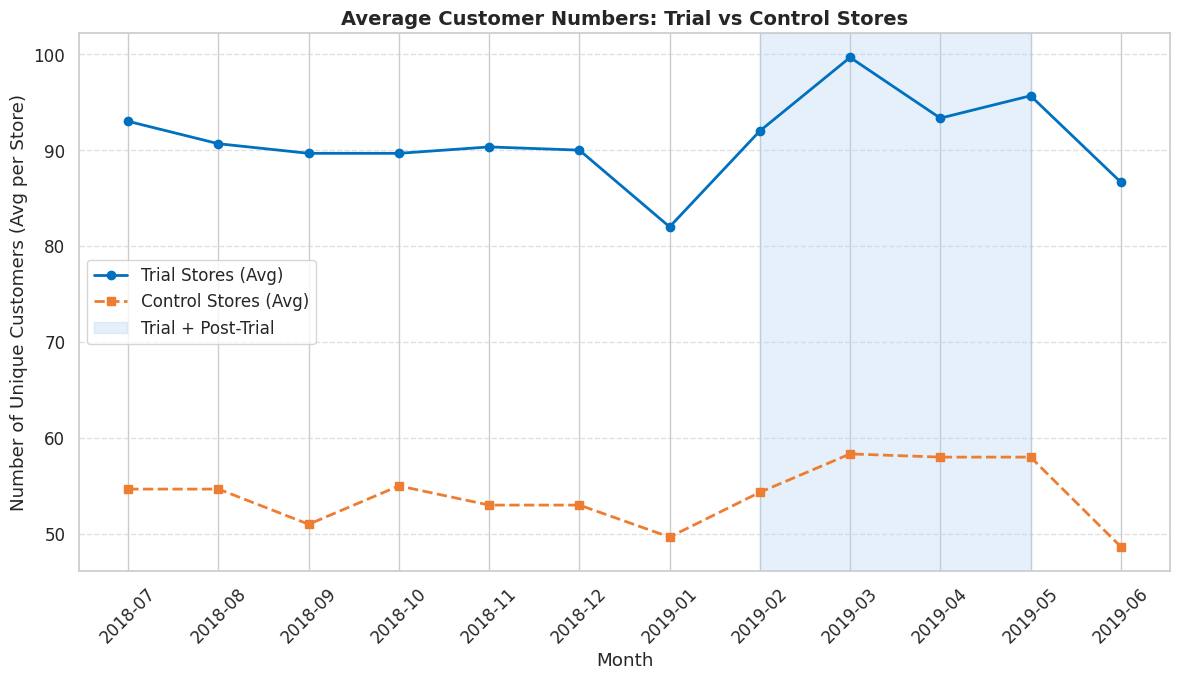

In [ ]:
# === Combined Customer Numbers for All Trial Stores vs Controls ===
trial_stores = [77, 86, 88]  # ensure defined

trial_color = "#0070C0"    # Blue for Trial
control_color = "#ED7D31"  # Orange for Control
shade_color = "#A9D0F5"    # Light blue for trial period shading

all_trial_customers = []
all_control_customers = []

for trial in trial_stores:
    control, _ = find_control_store(trial, 'CUSTOMERS')

    # Aggregate per store
    trial_cust = metrics[metrics['STORE_NBR'] == trial].groupby('MONTH')['CUSTOMERS'].mean()
    control_cust = metrics[metrics['STORE_NBR'] == control].groupby('MONTH')['CUSTOMERS'].mean()

    all_trial_customers.append(trial_cust)
    all_control_customers.append(control_cust)

# Combine across all stores (aligning on MONTH)
combined_trial = pd.concat(all_trial_customers, axis=1).mean(axis=1)
combined_control = pd.concat(all_control_customers, axis=1).mean(axis=1)

# Plot
plt.figure(figsize=(12,7))
plt.plot(combined_trial.index.astype(str), combined_trial.values,
         label="Trial Stores (Avg)", color=trial_color, marker="o", linewidth=2)
plt.plot(combined_control.index.astype(str), combined_control.values,
         label="Control Stores (Avg)", color=control_color, marker="s", linewidth=2, linestyle="--")

# Highlight trial period (Feb–Apr) + May
plt.axvspan('2019-02', '2019-05', color=shade_color, alpha=0.3, label="Trial + Post-Trial")

plt.title("Average Customer Numbers: Trial vs Control Stores", fontsize=14, fontweight="bold")
plt.xlabel("Month")
plt.ylabel("Number of Unique Customers (Avg per Store)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(axis='y', linestyle="--", alpha=0.6)
plt.tight_layout()
plt.savefig("combined_customer_numbers_trial_vs_control.png", dpi=300)
plt.show()